# WDSR

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from utils import evaluate, resolve, psnr

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

from PIL import Image

%matplotlib inline

In [2]:
# Super-resolution factor
scale = 4

# Model depth (number of residual blocks)
depth = 8

# Downgrade operator
downgrade = 'bicubic'

In [3]:
checkpoint_dir = f'.ckpt/wdsr-b-{depth}-x{scale}'
checkpoint_pattern = os.path.join(checkpoint_dir, 'ckpt-{epoch:02d}-{val_psnr:.2f}')

weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-8-x4.tar.gz](https://drive.google.com/open?id=1GFD0z1o3UXYvRORT486jnwZ9khSkz6Vv) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-8-x4` directory containing the weights of the pre-trained model.

### Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [ ]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

In [ ]:
optimizer = Adam(learning_rate=PiecewiseConstantDecay([200000], [1e-3, 5e-4]))
checkpoint = ModelCheckpoint(checkpoint_pattern, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_psnr',
                             mode='max')

model = wdsr_b(scale=scale, num_res_blocks=depth)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[psnr])

history = model.fit(train_ds, 
                    epochs=300, 
                    steps_per_epoch=1000, 
                    validation_data=valid_ds.take(10), 
                    callbacks=[checkpoint])

In [ ]:
ckpt = tf.train.Checkpoint()
ckpt_mgr = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=None)

model.load_weights(ckpt_mgr.latest_checkpoint);

In [ ]:
# Compute PSNR on full DIV2K validation set
eval_psnr = evaluate(model, valid_ds)
print(f'PSNR = {eval_psnr.numpy():3f}')

In [ ]:
# Save weights of latest checkpoint
model.save_weights(weights_file)

## Demo

In [4]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [5]:
def plot_sample(lr_image_path):
    lr = np.expand_dims(Image.open(lr_image_path), axis=0)
    sr = resolve(model, lr)

    plt.figure(figsize=(20, 10))

    images = [lr[0], sr[0]]
    titles = ['LR', f'SR (x{scale})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

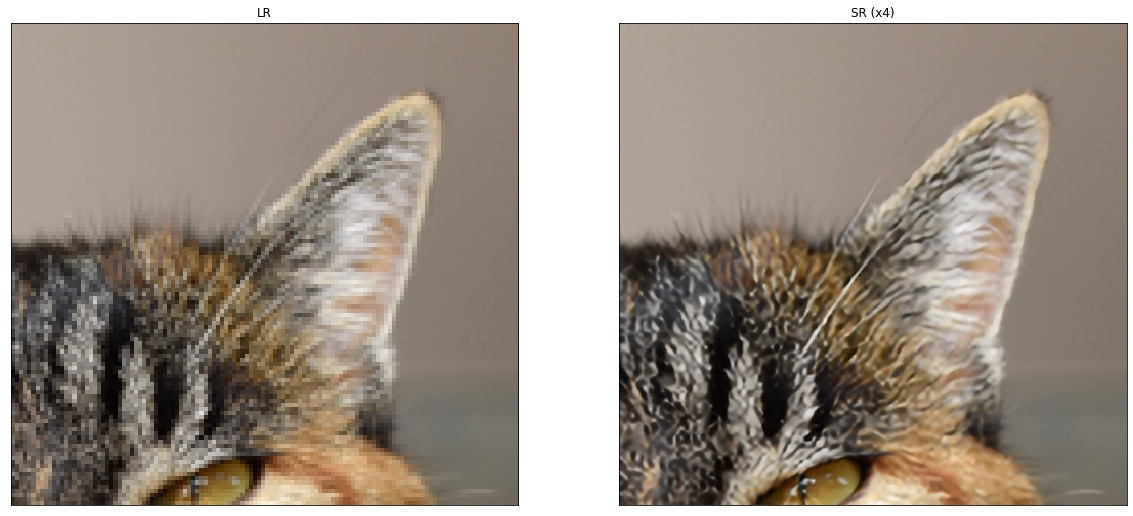

In [6]:
plot_sample('demo/0869x4-crop.png')

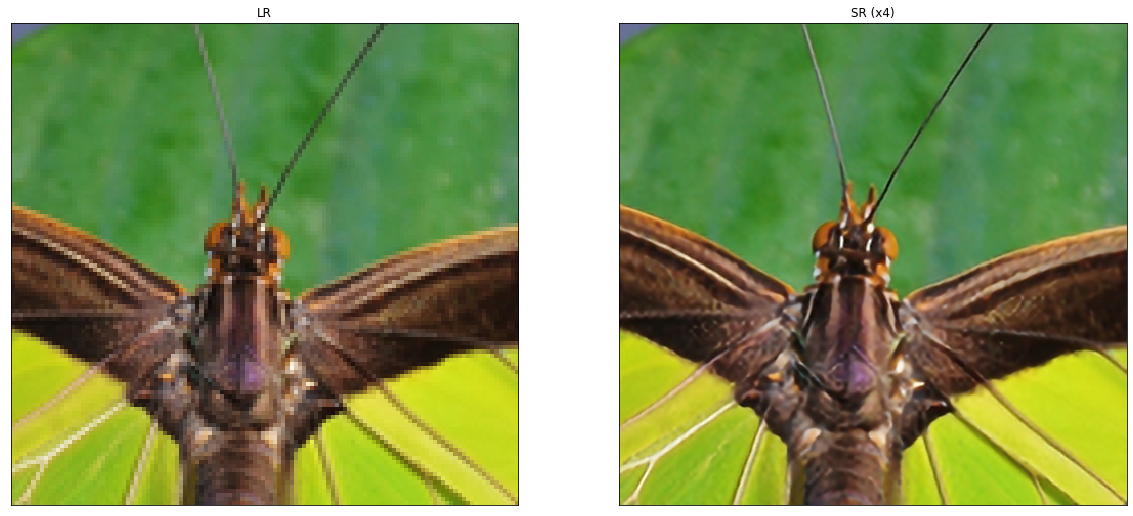

In [7]:
plot_sample('demo/0829x4-crop.png')

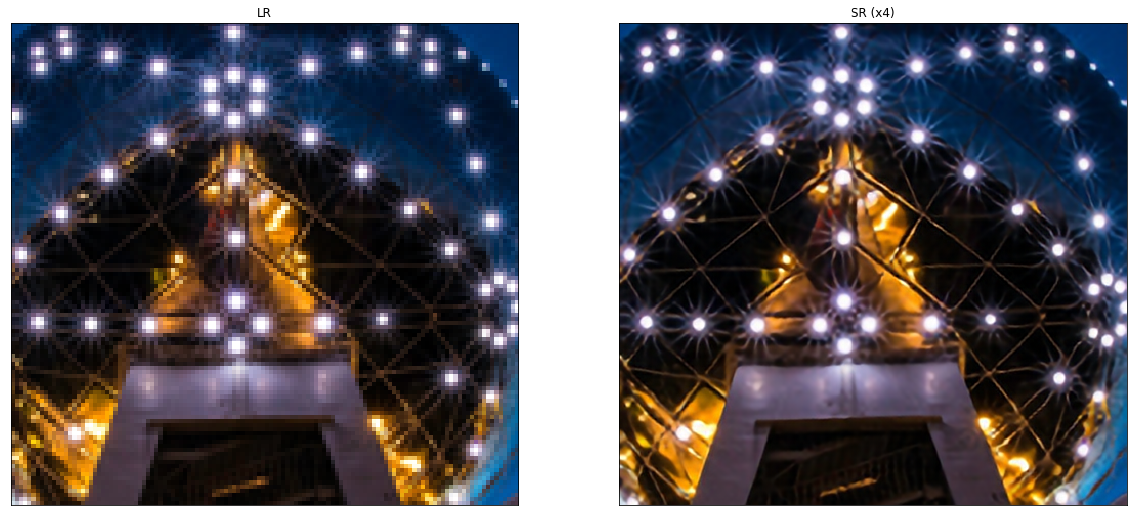

In [8]:
plot_sample('demo/0851x4-crop.png')